In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
from model.feature_extractor import DenseNetFE
from model.transformer import Transformer
from model.attention import MultiHeadAttention

In [13]:
from data import get_data_loader, get_vocab, SOS_CHAR, EOS_CHAR, PAD_CHAR
from torchvision import transforms
from utils import ScaleImageByHeight
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage
import math

In [27]:
device = 'cuda'
CKPT = './BEST_weights.pt'

print('Device = {}'.format(device))
print('Load weight from {}'.format(CKPT))
checkpoint = torch.load(CKPT, map_location=device)
config = checkpoint['config']

cnn = DenseNetFE(config['densenet']['depth'],
                 config['densenet']['n_blocks'],
                 config['densenet']['growth_rate'])

vocab = get_vocab(config['common']['dataset'])
model = Transformer(cnn, vocab.vocab_size, config['tf'])
model = nn.DataParallel(model)
model.to(device)

model.load_state_dict(checkpoint['model'])
# for name, module in model.named_modules():
#     if isinstance(module, MultiHeadAttention):
#         named_modules[name] = module
#         module.register_forward_hook(hook_fn)

test_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(config['common']['scale_height']),
    transforms.ToTensor(),
])

test_loader = get_data_loader(config['common']['dataset'], 'test', 1,
                              test_transform, vocab)

Device = cuda
Load weight from ./BEST_weights.pt


In [28]:
iter_test_loader = iter(test_loader)

In [35]:
model.eval()
with torch.no_grad():
    imgs, targets, targets_onehot, lengths = next(iter_test_loader)
    imgs = imgs.to(device)
    targets = targets.to(device)
    targets_onehot = targets_onehot.to(device)

    outputs, weights = model.module.greedy(imgs, targets_onehot[[0]].transpose(0,1), output_weights=True)
    outputs = outputs.topk(1, -1)[1]
    outputs, targets = outputs.squeeze(-1), targets[1:].transpose(0,1).squeeze(-1)
    outputs = outputs.cpu()
    targets = targets.cpu()

['n', 'ă', 'm', '<end>']/['n', 'ă', 'm', '<end>']


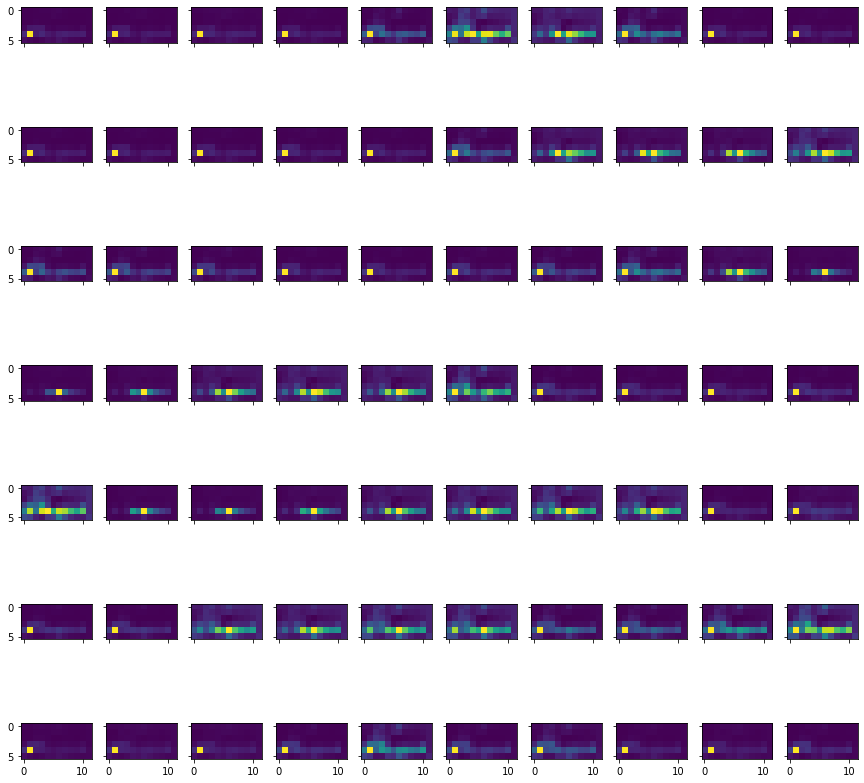

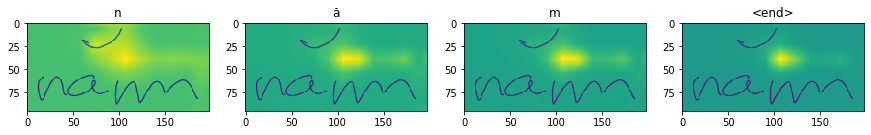

In [36]:
def plot_attention(imgs, predicted, groundtruth, weights):
    imgs = imgs.cpu().squeeze(0) # remove batch_size dim
    imgs = imgs.permute(1,2,0).numpy() # [C,H,W] -> [H,W,C]
    image_rows, image_cols = imgs.shape[:2]
    image_rows, image_cols = round(image_rows/16), round(image_cols/16) # 16 is factor of DenseNet
    # plt.imshow(imgs)

    encoder_weight, decoder_weight = weights
    encoder_weight = encoder_weight[0] # layer 0
    decoder_weight = decoder_weight[0] # layer 0

    # Plot encoder's weights
    encoder_weight = encoder_weight.squeeze(0).cpu().numpy() # remove batch_size dim
    fig, axeses = plt.subplots(7, len(encoder_weight) // 7, figsize=(15,15), sharex=True, sharey=True)
    for t, axes in enumerate(axeses.ravel()):
        if t >= len(encoder_weight):
            break
        weight = encoder_weight[t].reshape(image_rows, image_cols)
        axes.imshow(weight)

    text_weight, text_image_weight = decoder_weight
    text_weight = text_weight[0].cpu() # remove batch_size dim
    
    text_image_weight = text_image_weight[0].cpu() # remove batch_size dim
    text_image_weight = text_image_weight.reshape(-1, image_rows, image_cols)

    predicted = predicted.squeeze(0) # remove batch_size dim
    groundtruth = groundtruth.squeeze(0) # remove batch_size dim

    predicted = [vocab.int2char[val] for val in predicted.tolist()]
    predicted = predicted[:predicted.index(EOS_CHAR) + 1]
    # predicted = ''.join(predicted)round(

    groundtruth = [vocab.int2char[val] for val in groundtruth.tolist()]
    groundtruth = groundtruth[:groundtruth.index(EOS_CHAR) + 1]
    # groundtruth = ''.join(groundtruth)

    print('{}/{}'.format(predicted, groundtruth))

    fig, axeses = plt.subplots(1, len(predicted), figsize=(15,15))

    for t, axes in enumerate(axeses.ravel()):
        predict_char = predicted[t]
        axes.set_title(predicted[t])

        text_image_w = text_image_weight[t]
        text_image_w = skimage.transform.resize(text_image_w, imgs.shape[:2])
        
        alpha = 0.2
        blend = imgs[:,:,0] * alpha + text_image_w * (1-alpha)
        axes.imshow(blend)

plot_attention(imgs, outputs, targets, weights)

# Visualize a sample

In [ ]:
sample_index = 1
sample_image, sample_predict, sample_weigth = imgs[sample_index], predicts_str[sample_index], weights[:, [sample_index]]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)

for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, config['batch_size'], img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.cpu().numpy()[:,sample_index,:].squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend, cmap='spring')
plt.plot();

# Calc CER, WER on the test set

## CER

In [29]:
import editdistance as ed

In [30]:
log_test = open('./log_test.txt', 'w+')

In [31]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

# t = tqdm(test_loader)
t = test_loader
with torch.no_grad():
    for i, (imgs, targets, targets_onehot, lengths) in enumerate(t):
        print(f'[{i}]/[{len(t)}]', file=log_test)
        log_test.flush()
        batch_size = imgs.size(0)
        
        imgs = imgs.to(device)
        img_features = encoder(imgs)
        targets_onehot = targets_onehot[1:].to(device)
        targets = targets[1:].to(device)
        lengths = lengths - 1
        outputs = decoder.forward(img_features, targets_onehot, targets, lengths, char2int[PAD_CHAR])
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for j in range(len(predicts_str)):
            CE += ed.distance(predicts_str[j], targets_str[j])
        total_characters += lengths.sum().item()
        
        for j in range(len(predicts_str)):
            if not np.array_equal(np.array(predicts_str[j]), np.array(targets_str[j])):
                WE += 1
                print(f'Batch {i} - sample {j}: "{predicts_str[j]}"/"{targets_str[j]}"')
        total_words += len(predicts_str)
        
#         t.update()

Batch 0 - sample 25: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 0 - sample 26: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 2 - sample 31: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 8 - sample 31: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 9 - sample 13: "['s', 's', 'n', '<end>']"/"['s', 'ẵ', 'n', '<end>']"
Batch 15 - sample 27: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 16 - sample 26: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 17 - sample 30: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 24 - sample 30: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 28 - sample 21: "['s', 's', 'n', '<end>']"/"['s', 'ẵ', 'n', '<end>']"
Batch 29 - sample 25: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 31 - sample 27: "['M', 'M', '<end>']"/"['M', 'ỹ', '<end>']"
Batch 39 - sample 22: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 39 - sample 28: "['k', 'k', '<end>']"/"['k', 'ỳ', '<end>']"
Batch 39 - sample 31: "['y', 'n', '<end>']"/"['Â', 'n', '<end

In [32]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER, file=log_test)
print('WER', WER, file=log_test)
log_test.flush()

In [33]:
log_test.close()

In [34]:
print(CE, total_characters, CER)

164 108614 0.0015099342626180786


In [35]:
print(WE, total_words, WER)

156 25115 0.0062114274338044995
